In [1]:
from IPython.display import display, Math
from collections import Counter
from collections import OrderedDict

import math
import simpy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def ro_i(ro, i):
    return ro ** i / math.factorial(i)

In [3]:
def split_list(alist, wanted_parts=1):
    length = len(alist)
    return [alist[i * length // wanted_parts: (i + 1) * length // wanted_parts]
            for i in range(wanted_parts)]

In [5]:
def theoretical(n, m, l, mu, v):
    ro, betta = l / mu, v / mu

    p = [(1 + sum([ro_i(ro, i) for i in range(1, n + 1)]) + ro_i(ro, n)
          * sum([ro ** i / np.prod([n + l * betta for l in range(1, i + 1)]) for i in range(1, m + 1)])) ** -1]
    for i in range(1, n + 1):
        pn = ro_i(ro, i) * p[0]
        p.append(pn)

    for i in range(1, m + 1):
        pni = p[n] * (ro ** i / np.prod([n + l * betta for l in range(1, i + 1)]))
        p.append(pni)
    # Вероятность образования очереди р_оч определяется формулой
    p_queue = p[n] + p[n + 1]
    # Вероятность отказа в обслуживании р_отк равна
    p_refusal = p[n + m]
    # Относительная пропускная способность Q равна
    Q = 1 - p_refusal
    # Абсолютная пропускная способность A равна
    A = l * Q
    # Среднее число заявок, находящихся в очереди, находится по формуле
    L_queue = sum([i * p[n + i] for i in range(1, m + 1)])
    # Среднее число заявок, обслуживаемых в СМО, находится по формуле
    L_service = sum([k * p[k] for k in range(1, n + 1)]) + sum([(n + i) * p[n + i] for i in range(1, m + 1)])
    # Среднее число занятых каналов
    n_avr_busy_workers = A / mu
    # Среднее время ожидания заявки в очереди
    t_queue = L_queue / l
    # Среднее время пребывания заявки в системе
    t_total = L_service / l

    print('Theoretical')
    display(Math(r'\text{ Финальные вероятности состояний }'))
    display(Math(
        r'p_{0}=\left(1+\frac{\rho}{1 !}+\frac{\rho^{2}}{2 !}+\ldots+\frac{\rho^{n}}{n !}+\frac{\rho^{n}}{n !} \cdot \sum_{i=1}^{m} \frac{\rho^{i}}{\prod_{l=1}^{i}(n+l \beta)}\right)^{-1}=' + str(
            p[0])))
    display(Math(r'p_{k}=\frac{\rho^{k}}{k !} \cdot p_{0}, \quad(k=\overline{1, n})'))
    for i in range(1, n + 1):
        display(Math(f'p_{i}=' + str(p[i])))
    display(Math(r'p_{n+i}=p_{n} \cdot \frac{\rho^{i}}{\prod_{l=1}^{i}(n+l \beta)}, \quad(i=\overline{1, m})'))
    for i in range(n + 1, n + m + 1):
        display(Math(f'p_{i}=' + str(p[i])))
    display(Math(r'\text{Вероятность образования очереди определяется формулой}'))
    display(Math(
        r'p_{оч}=\sum_{i=0}^{m=1} p_{n+i}=p_{n} \cdot\left(1+\sum_{i=1}^{m-1} \frac{\rho^{i}}{\prod_{l=1}^{i}(n+l \beta)}\right)=' + str(
            p_queue)))
    display(Math(
        r'\text{Отказ в обслуживании заявки происходит, когда все m мест в очереди заняты, т.е. вероятность отказа в обслуживании равна}'))
    display(Math(r'p_{o m \kappa}=p_{n+m}=p_{n} \cdot \frac{\rho^{m}}{\prod_{l=1}^{m}(n+l \beta)}=' + str(p_refusal)))
    display(Math(r'\text{ Относительная пропускная способность равна }'))
    display(Math(
        r'Q=p_{\text {oбc. }}=1-p_{\text {отк. }}=1-p_{n} \cdot \frac{\rho^{m}}{\prod_{l=1}^{m}(n+l \beta)}=' + str(Q)))
    display(Math(r'\text{Абсолютная пропускная способность}'))
    display(Math(r'A=\lambda Q=' + str(A)))
    display(Math(r'\text{Среднее число заявок, находящихся в очереди, находится по формуле}'))
    display(Math(
        r'L_{oч}=\sum_{i=1}^{m} i p_{n+i}=p_{n} \cdot \sum_{i=1}^{m} \frac{i \cdot \rho^{i}}{\prod_{l=1}^{i}(n+l \beta)}=' + str(
            L_queue)))
    display(Math(r'\text{Среднее число заявок, обслуживаемых в СМО, находится по формуле}'))
    display(Math(r'L_{o б c}=\sum_{k=1}^{n} k \cdot p_{k}+\sum_{i=1}^{m} n \cdot p_{n+i}=' + str(L_service)))
    display(Math(r'\text{ Среднее число занятых каналов }'))
    display(Math(r'\bar{k}=\frac{A}{\mu}=' + str(n_avr_busy_workers)))
    display(Math(r'\text{ Среднее время ожидания заявки в очереди }'))
    display(Math(r't=\frac{L}{\lambda}=' + str(t_queue)))
    display(Math(r'\text{ Среднее время пребывания заявки в системе }'))
    display(Math(r'T=t+\frac{1}{\mu},=' + str(t_total)))

    return p



In [117]:
def empirical(
        time_spent_in_queue, time_spent_in_system,
        counter_users_in_queue, counter_users_in_system,
        n, m, n_service, n_not_service, until,
):
    print('Empirical')
    p = [v / len(counter_users_in_system) for _, v in dict(Counter(counter_users_in_system)).items()]
    # Вероятность образования очереди р_оч определяется формулой
    p_queue = p[n] + p[n + 1]
    # Вероятность отказа в обслуживании р_отк равна
    p_refusal = p[n + m]
    # Относительная пропускная способность Q равна
    Q = 1 - p_refusal
    # Абсолютная пропускная способность A равна
    A = n_not_service  / until
    # Среднее число заявок, находящихся в очереди, находится по формуле
    L_queue = sum([p[i] * (i - n) for i in range(n + 1, n + m + 1)])
    # Среднее число заявок, обслуживаемых в СМО, находится по формуле
    L_service = sum([k * p[k] for k in range(1, n + 1)]) + sum([(n + i) * p[n + i] for i in range(1, m + 1)])
    # Среднее число занятых каналов
    n_avr_busy_workers = sum([p[i] * i for i in range(n + m + 1)])
    # Среднее время ожидания заявки в очереди
    t_queue = sum(time_spent_in_queue) / len(time_spent_in_queue)
    # Среднее время пребывания заявки в системе
    t_total = sum(time_spent_in_system) / len(time_spent_in_system)

    display(Math(r'\text{ Финальные вероятности состояний }'))
    for i in range(0, n + m + 1):
        display(Math(f'p_{i}=' + str(p[i])))
    display(Math(r'\text{Вероятность образования очереди определяется формулой}'))
    display(Math(r'p_{оч}=' + str(p_queue)))
    display(Math(r'\text{Вероятность отказа в обслуживании равна}'))
    display(Math(r'p_{o m \kappa}=' + str(p_refusal)))
    display(Math(r'\text{ Относительная пропускная способность равна }'))
    display(Math(r'Q=' + str(Q)))
    display(Math(r'\text{Абсолютная пропускная способность}'))
    display(Math(r'A=' + str(A)))
    display(Math(r'\text{Среднее число заявок, находящихся в очереди, находится по формуле}'))
    display(Math(r'L_{oч}=' + str(L_queue)))
    display(Math(r'\text{Среднее число заявок, находящихся в СМО, находится по формуле}'))
    display(Math(r'L_{o б c}=' + str(L_service)))
    display(Math(r'\text{ Среднее число занятых каналов }'))
    display(Math(r'\bar{k}=' + str(n_avr_busy_workers)))
    display(Math(r'\text{ Среднее время ожидания заявки в очереди }'))
    display(Math(r't=' + str(t_queue)))
    display(Math(r'\text{ Среднее время пребывания заявки в системе }'))
    display(Math(r'T=' + str(t_total)))

In [118]:
class Queueing(object):
    def __init__(self, env, n, m, l, mu, v):
        self.mu, self.v, self.env = mu, v, env
        self.n, self.m, self.l = n, m, l
        self.worker = simpy.Resource(env, n)
        self.time_spent_in_queue, self.time_spent_in_system = [], []
        self.counter_users_in_queue, self.counter_users_in_system = [], []
        self.n, self.n_service = 0, 0

    def service_request(self):
        yield self.env.timeout(np.random.exponential(1 / self.mu))


In [119]:
def make_request(env, queueing):
    start_time = env.now
    len_queue = len(queueing.worker.queue)
    worker_busy = queueing.worker.count
    with queueing.worker.request() as request:
        queueing.counter_users_in_queue.append(len_queue)
        queueing.counter_users_in_system.append(len_queue + worker_busy)
        if len(queueing.worker.queue) <= queueing.m:
            queueing.n += 1
            patience = np.random.exponential(1 / queueing.v)
            result = yield request | env.timeout(patience)
            queueing.time_spent_in_queue.append(env.now - start_time)
            if request in result:
                yield env.process(queueing.service_request())
                queueing.n_service += 1
            queueing.time_spent_in_system.append(env.now - start_time)
        else:
            queueing.time_spent_in_queue.append(0)
            queueing.time_spent_in_system.append(0)


In [120]:
def run_queuing(env, queueing):
    while True:
        yield env.timeout(np.random.exponential(1 / queueing.l))
        env.process(make_request(env=env, queueing=queueing))

In [121]:
def show_histogram(values: np.arange, component_name: str, theoretical) -> None:
    sns.set_style("darkgrid")
    plt.figure(dpi=120, figsize=(8, 5))
    plt.bar(list(range(len(values))), values, color=sns.color_palette('deep')[2], linewidth=0)
    plt.title("Histogram of " + component_name )
    plt.xlabel("кол-во времени")
    plt.ylabel("Вероятность")
    plt.hlines(theoretical, 0, 60)
    # sns.histplot(values, palette='deep', color=sns.color_palette('deep')[1], linewidth=2, binwidth=0.4)
    # plt.legend((theoretical + "- theoretical", ''))
    plt.legend([str(theoretical) + " - theoretical", component_name,])
    plt.show()

In [122]:
def main(n, m, l, mu, v, until, plot=False):
    env = simpy.Environment()
    queueing = Queueing(n=n, m=m, l=l, mu=mu, v=v, env=env)
    env.process(run_queuing(env=env, queueing=queueing))
    env.run(until=until)
    p = theoretical(n=n, m=m, l=l, mu=mu, v=v)
    empirical(
        time_spent_in_queue=queueing.time_spent_in_queue,
        time_spent_in_system=queueing.time_spent_in_system,
        counter_users_in_queue=queueing.counter_users_in_queue,
        counter_users_in_system=queueing.counter_users_in_system,
        n=n, m=m, n_service=queueing.n_service, n_not_service=queueing.n,
        until=until,
    )
    if plot:
        parts = split_list(queueing.counter_users_in_system, wanted_parts=60)
        for i in range(1, len(parts)):
            parts[i].extend(parts[i - 1])
        P = []
        for part in parts:
            P.append(np.array(
                list(v / len(part) for _, v in dict(OrderedDict(sorted(dict(Counter(part)).items()))).items())))
        P = np.array(P).transpose()
        for i in range(n + m + 1):
            show_histogram(P[i], f"p{i}", p[i])

In [123]:
main(n=1, m=1, l=1, mu=1, v=1, until=10000)

Theoretical


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Empirical


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [128]:
main(n=4, m=2, l=5, mu=6, v=3, until=10000)

Theoretical


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Empirical


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Theoretical


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Empirical


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

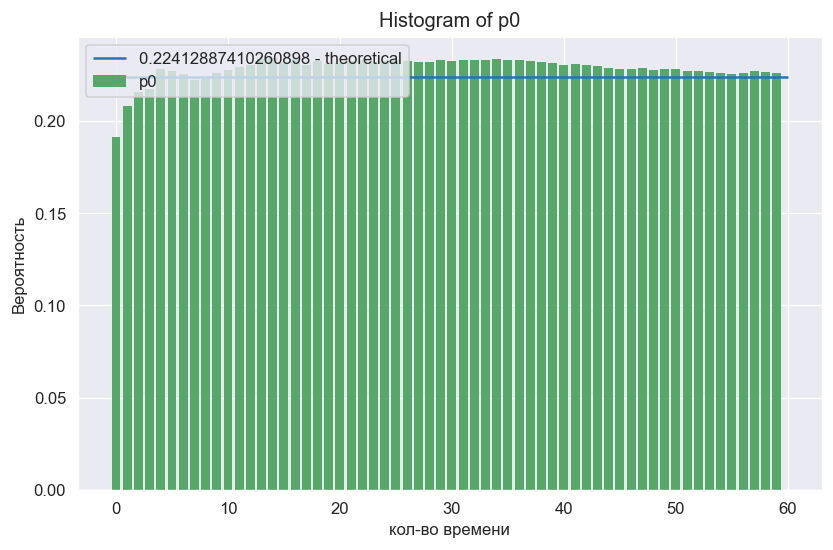

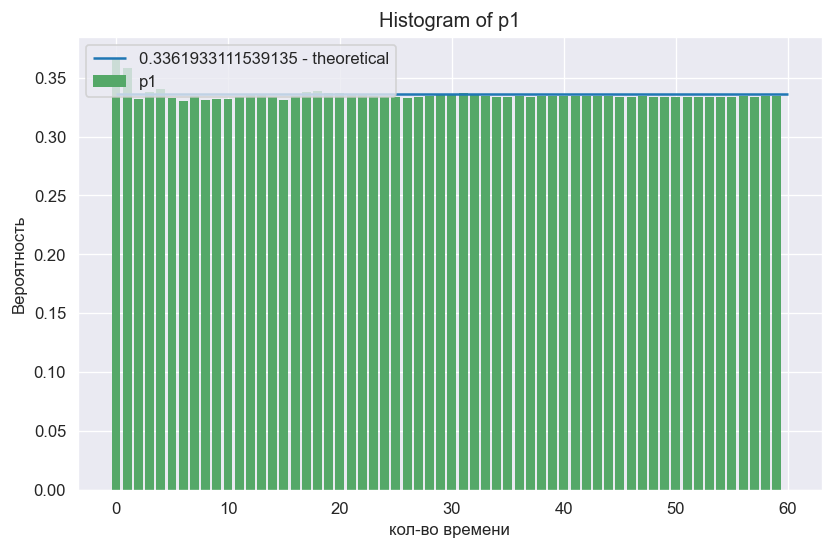

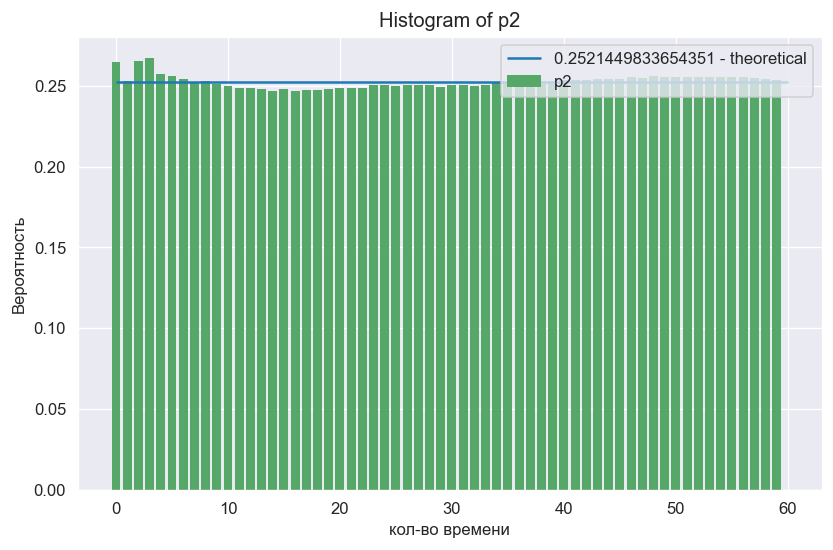

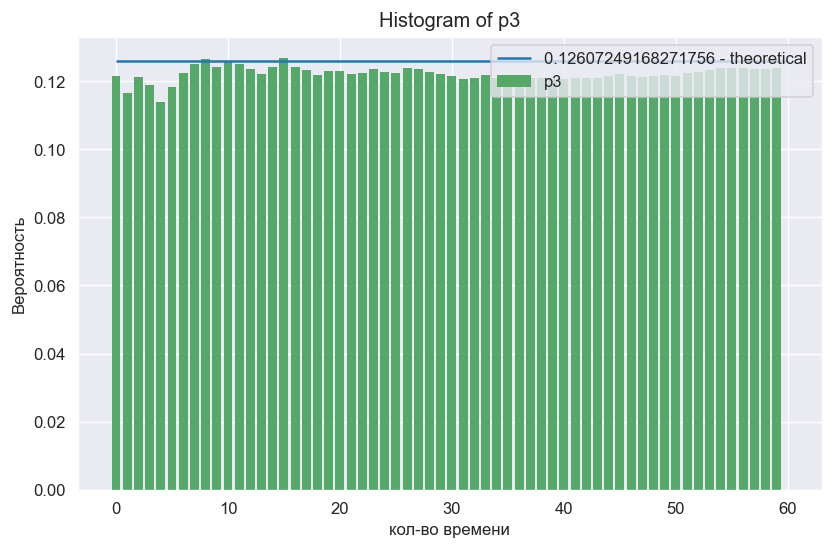

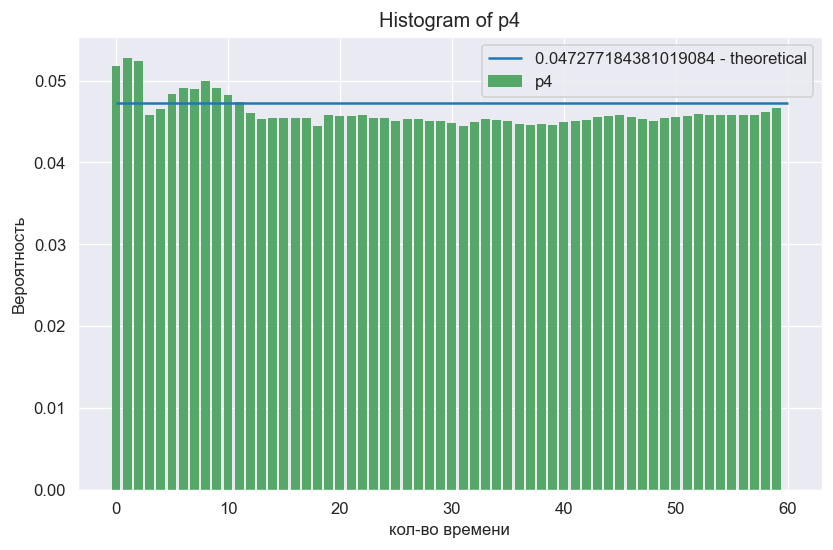

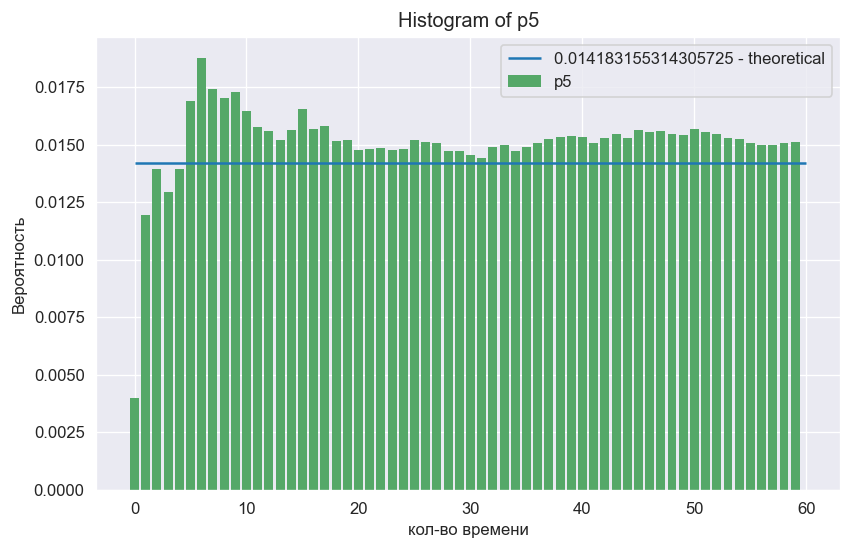

In [124]:
main(n=3, m=2, l=3, mu=2, v=2, until=10000, plot=True)